In [1]:
import gym
import gym.wrappers
import tianshou as ts
import torch
import numpy as np
import platoonenv
from typing import Union
from pprint import pprint

In [2]:
# envName = "CartPole-v0"
# envName = "MountainCar-v0"
# envName = "Acrobot-v1"
envName = "Platoon-v0"
params=platoonenv.PlatoonEnvParams(
    num_vehicles=10,
    num_vulns=4,
    num_attack=1,
    attack_interval=600
)
def make_env(render_mode: Union[str, None] = None):
    if envName == "Platoon-v0":
        env = gym.make(envName, render_mode=render_mode, params=params)
        # env = gym.wrappers.TimeLimit(env, max_episode_steps=100)
        env = gym.wrappers.TimeLimit(env, max_episode_steps=10)
    else:
        env = gym.make(envName, render_mode=render_mode)
    return env
env = make_env(render_mode="human")

In [3]:
obs_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
print(obs_shape)
print(action_shape)

(10,)
11


In [4]:
from itertools import count
from time import sleep
for i in range(5):
    env.reset()
    reward = 0
    for j in count():
        env.render()
        # sleep(1)
        obs, rew, done, trunc, info = env.step(env.action_space.sample())
        reward += rew
        if trunc or done:
            env.reset()
            print(f"done after {j} steps with {reward} reward")
            break
print(i, "episodes done")

done after 9 steps with -70 reward
done after 9 steps with -72 reward
done after 9 steps with -76 reward
done after 9 steps with -53 reward
done after 9 steps with -67 reward
4 episodes done


In [5]:
env.reset()
reward = 0
for i in range(env.action_space.n):
    obs, rew, done, trunc, info = env.step(i)
    reward += rew
    print(f"action {i} reward {rew} obs {obs}")
print(f"Total reward was {reward}")
env.render()

action 0 reward -9 obs [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action 1 reward -8 obs [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
action 2 reward -7 obs [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
action 3 reward -6 obs [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
action 4 reward -5 obs [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
action 5 reward -4 obs [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
action 6 reward -3 obs [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
action 7 reward -2 obs [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
action 8 reward -1 obs [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
action 9 reward 0 obs [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
action 10 reward 0 obs [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Total reward was -45


(array([8776., 9064., 9077., 9047., 9023., 9138., 9082., 9079., 9333.,
        9324., 9057.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

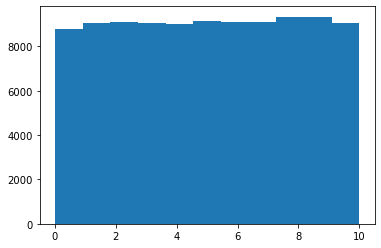

In [6]:
import matplotlib.pyplot as plt
plt.hist([env.action_space.sample() for _ in range(100000)], bins=env.action_space.n)

In [7]:
train_envs = ts.env.DummyVectorEnv([lambda: make_env() for _ in range(10)])
test_envs = ts.env.DummyVectorEnv([lambda: make_env() for _ in range(100)])

In [8]:
seed=15
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)
pass

In [9]:
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
# hidden_sizes=(128,128,128,128)
hidden_sizes=(12,12,12)
net = Net(obs_shape, hidden_sizes=hidden_sizes)
actor = Actor(net, action_shape, softmax_output=True)
actor_optim = torch.optim.Adam(actor.parameters(), lr=1e-4)
net_c1 = Net(obs_shape, hidden_sizes=hidden_sizes)
critic1 = Critic(net_c1, last_size=action_shape)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=1e-3)
net_c2 = Net(obs_shape, hidden_sizes=hidden_sizes)
critic2 = Critic(net_c2, last_size=action_shape)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=1e-3)

In [10]:
# policy = ts.policy.DQNPolicy(net, optim, discount_factor=0.9, estimation_step=3, target_update_freq=320)
alpha = 0.05
alpha_lr = 3e-4
# auto_alpha = True
auto_alpha = False
if auto_alpha:
    target_entropy = 0.98 * np.log(np.prod(action_shape))
    log_alpha = torch.zeros(1, requires_grad=True)
    alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
    alpha = (target_entropy, log_alpha, alpha_optim)

In [11]:
from tianshou.exploration import OUNoise
policy = ts.policy.DiscreteSACPolicy(
    actor, actor_optim,
    critic1, critic1_optim,
    critic2, critic2_optim,
    0.005, # tau
    0.95, # gamma
    alpha,
    estimation_step = 3,
    reward_normalization = False,
    # exploration_noise=OUNoise(0.0, 1.2),
)

In [12]:
from tianshou.data import VectorReplayBuffer
train_collector = ts.data.Collector(policy, train_envs, VectorReplayBuffer(20000, 10), exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)

In [13]:
# train_collector.collect(n_step=5000, random=True)

In [14]:
threshold = env.spec.reward_threshold or -45
print("Threshold:", threshold)

Threshold: -45


In [15]:
from tianshou.utils import TensorboardLogger
from torch.utils.tensorboard import SummaryWriter
import os
log_path = os.path.join("log", envName, 'tianplatoon.ipynb')
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [16]:
result = ts.trainer.offpolicy_trainer(
    policy,
    train_collector,
    test_collector,
    max_epoch=100,
    step_per_epoch=10000,
    step_per_collect=10,
    # update_per_step=1,
    update_per_step=0.1,
    test_in_train=False,
    episode_per_test=100,
    batch_size=640,
    stop_fn=lambda mean_rewards: mean_rewards >= threshold,
    logger=logger
)
print(f"Finished training! Use {result['duration']}")

Epoch #1: 10001it [00:13, 716.85it/s, env_step=10000, len=10, loss/actor=49.250, loss/critic1=25.248, loss/critic2=25.324, n/ep=10, n/st=10, rew=-67.60]                           


Epoch #1: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #2: 10001it [00:13, 750.47it/s, env_step=20000, len=10, loss/actor=76.047, loss/critic1=39.253, loss/critic2=38.494, n/ep=10, n/st=10, rew=-69.50]                           


Epoch #2: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #3: 10001it [00:13, 748.53it/s, env_step=30000, len=10, loss/actor=91.264, loss/critic1=36.724, loss/critic2=36.343, n/ep=10, n/st=10, rew=-70.00]                           


Epoch #3: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #4: 10001it [00:13, 737.99it/s, env_step=40000, len=10, loss/actor=100.690, loss/critic1=34.103, loss/critic2=35.206, n/ep=10, n/st=10, rew=-73.70]                           


Epoch #4: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #5: 10001it [00:13, 740.16it/s, env_step=50000, len=10, loss/actor=106.947, loss/critic1=30.655, loss/critic2=31.969, n/ep=10, n/st=10, rew=-73.30]                           


Epoch #5: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #6: 10001it [00:13, 745.99it/s, env_step=60000, len=10, loss/actor=110.876, loss/critic1=27.723, loss/critic2=28.899, n/ep=10, n/st=10, rew=-76.10]                           


Epoch #6: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #7: 10001it [00:13, 748.32it/s, env_step=70000, len=10, loss/actor=113.195, loss/critic1=26.907, loss/critic2=28.295, n/ep=10, n/st=10, rew=-70.90]                           


Epoch #7: test_reward: -95.000000 ± 0.000000, best_reward: -95.000000 ± 0.000000 in #0


Epoch #8: 10001it [00:13, 742.48it/s, env_step=80000, len=10, loss/actor=113.795, loss/critic1=28.200, loss/critic2=29.213, n/ep=10, n/st=10, rew=-67.90]                           


Epoch #8: test_reward: -85.000000 ± 0.000000, best_reward: -85.000000 ± 0.000000 in #8


Epoch #9: 10001it [00:13, 741.83it/s, env_step=90000, len=10, loss/actor=112.747, loss/critic1=29.746, loss/critic2=30.747, n/ep=10, n/st=10, rew=-69.20]                           


Epoch #9: test_reward: -77.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #10: 10001it [00:13, 737.37it/s, env_step=100000, len=10, loss/actor=110.868, loss/critic1=29.487, loss/critic2=30.207, n/ep=10, n/st=10, rew=-70.40]                           


Epoch #10: test_reward: -77.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #11: 10001it [00:13, 739.43it/s, env_step=110000, len=10, loss/actor=109.723, loss/critic1=27.483, loss/critic2=27.978, n/ep=10, n/st=10, rew=-63.10]                           


Epoch #11: test_reward: -85.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #12: 10001it [00:13, 739.06it/s, env_step=120000, len=10, loss/actor=109.765, loss/critic1=25.563, loss/critic2=26.151, n/ep=10, n/st=10, rew=-66.00]                           


Epoch #12: test_reward: -85.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #13: 10001it [00:13, 731.05it/s, env_step=130000, len=10, loss/actor=110.032, loss/critic1=25.175, loss/critic2=26.202, n/ep=10, n/st=10, rew=-67.60]                           


Epoch #13: test_reward: -77.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #14: 10001it [00:15, 658.54it/s, env_step=140000, len=10, loss/actor=110.122, loss/critic1=25.747, loss/critic2=26.692, n/ep=10, n/st=10, rew=-70.00]                           


Epoch #14: test_reward: -77.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #15: 10001it [00:15, 648.77it/s, env_step=150000, len=10, loss/actor=110.604, loss/critic1=26.222, loss/critic2=27.014, n/ep=10, n/st=10, rew=-70.10]                           


Epoch #15: test_reward: -77.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #16: 10001it [00:13, 720.69it/s, env_step=160000, len=10, loss/actor=110.469, loss/critic1=27.120, loss/critic2=27.653, n/ep=10, n/st=10, rew=-68.10]                           


Epoch #16: test_reward: -85.000000 ± 0.000000, best_reward: -77.000000 ± 0.000000 in #9


Epoch #17: 10001it [00:14, 697.42it/s, env_step=170000, len=10, loss/actor=110.418, loss/critic1=26.047, loss/critic2=26.490, n/ep=10, n/st=10, rew=-66.40]                           


Epoch #17: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #18: 10001it [00:14, 713.98it/s, env_step=180000, len=10, loss/actor=110.628, loss/critic1=25.426, loss/critic2=25.702, n/ep=10, n/st=10, rew=-70.90]                           


Epoch #18: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #19: 10001it [00:14, 710.04it/s, env_step=190000, len=10, loss/actor=110.579, loss/critic1=24.743, loss/critic2=25.367, n/ep=10, n/st=10, rew=-69.40]                           


Epoch #19: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #20: 10001it [00:13, 715.43it/s, env_step=200000, len=10, loss/actor=110.818, loss/critic1=25.164, loss/critic2=25.904, n/ep=10, n/st=10, rew=-70.90]                           


Epoch #20: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #21: 10001it [00:14, 708.66it/s, env_step=210000, len=10, loss/actor=111.042, loss/critic1=25.369, loss/critic2=26.351, n/ep=10, n/st=10, rew=-66.50]                           


Epoch #21: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #22: 10001it [00:13, 721.45it/s, env_step=220000, len=10, loss/actor=110.703, loss/critic1=24.673, loss/critic2=25.247, n/ep=10, n/st=10, rew=-70.50]                           


Epoch #22: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #23: 10001it [00:13, 729.66it/s, env_step=230000, len=10, loss/actor=110.653, loss/critic1=25.146, loss/critic2=26.075, n/ep=10, n/st=10, rew=-64.40]                           


Epoch #23: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #24: 10001it [00:13, 715.66it/s, env_step=240000, len=10, loss/actor=110.799, loss/critic1=25.028, loss/critic2=26.129, n/ep=10, n/st=10, rew=-61.50]                           


Epoch #24: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #25: 10001it [00:13, 732.52it/s, env_step=250000, len=10, loss/actor=110.589, loss/critic1=24.772, loss/critic2=25.663, n/ep=10, n/st=10, rew=-65.30]                           


Epoch #25: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #26: 10001it [00:13, 727.18it/s, env_step=260000, len=10, loss/actor=110.372, loss/critic1=23.645, loss/critic2=24.701, n/ep=10, n/st=10, rew=-67.10]                           


Epoch #26: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #27: 10001it [00:13, 728.29it/s, env_step=270000, len=10, loss/actor=110.510, loss/critic1=23.248, loss/critic2=24.334, n/ep=10, n/st=10, rew=-65.60]                           


Epoch #27: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #28: 10001it [00:13, 728.05it/s, env_step=280000, len=10, loss/actor=110.803, loss/critic1=23.035, loss/critic2=24.325, n/ep=10, n/st=10, rew=-64.40]                           


Epoch #28: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #29: 10001it [00:13, 742.95it/s, env_step=290000, len=10, loss/actor=110.584, loss/critic1=23.441, loss/critic2=24.520, n/ep=10, n/st=10, rew=-66.30]                           


Epoch #29: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #30: 10001it [00:13, 739.34it/s, env_step=300000, len=10, loss/actor=109.946, loss/critic1=24.557, loss/critic2=25.861, n/ep=10, n/st=10, rew=-69.60]                           


Epoch #30: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #31: 10001it [00:13, 743.59it/s, env_step=310000, len=10, loss/actor=109.297, loss/critic1=23.920, loss/critic2=25.288, n/ep=10, n/st=10, rew=-68.30]                           


Epoch #31: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #32: 10001it [00:13, 730.84it/s, env_step=320000, len=10, loss/actor=109.126, loss/critic1=23.601, loss/critic2=25.115, n/ep=10, n/st=10, rew=-68.90]                           


Epoch #32: test_reward: -69.000000 ± 0.000000, best_reward: -69.000000 ± 0.000000 in #17


Epoch #33: 10001it [00:14, 709.28it/s, env_step=330000, len=10, loss/actor=109.393, loss/critic1=23.359, loss/critic2=25.102, n/ep=10, n/st=10, rew=-66.50]                           


Epoch #33: test_reward: -67.000000 ± 0.000000, best_reward: -67.000000 ± 0.000000 in #33


Epoch #34: 10001it [00:14, 709.80it/s, env_step=340000, len=10, loss/actor=109.290, loss/critic1=23.525, loss/critic2=25.226, n/ep=10, n/st=10, rew=-67.00]                           


Epoch #34: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #35: 10001it [00:14, 705.65it/s, env_step=350000, len=10, loss/actor=108.289, loss/critic1=23.876, loss/critic2=25.890, n/ep=10, n/st=10, rew=-71.10]                           


Epoch #35: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #36: 10001it [00:14, 676.63it/s, env_step=360000, len=10, loss/actor=108.105, loss/critic1=23.612, loss/critic2=25.353, n/ep=10, n/st=10, rew=-69.50]                           


Epoch #36: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #37: 10001it [00:14, 683.81it/s, env_step=370000, len=10, loss/actor=108.104, loss/critic1=22.788, loss/critic2=24.141, n/ep=10, n/st=10, rew=-65.30]                           


Epoch #37: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #38: 10001it [00:14, 711.46it/s, env_step=380000, len=10, loss/actor=107.873, loss/critic1=22.964, loss/critic2=24.228, n/ep=10, n/st=10, rew=-67.60]                           


Epoch #38: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #39: 10001it [00:13, 725.09it/s, env_step=390000, len=10, loss/actor=107.409, loss/critic1=24.118, loss/critic2=25.606, n/ep=10, n/st=10, rew=-69.10]                           


Epoch #39: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #40: 10001it [00:13, 715.49it/s, env_step=400000, len=10, loss/actor=106.913, loss/critic1=24.348, loss/critic2=26.328, n/ep=10, n/st=10, rew=-70.90]                           


Epoch #40: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #41: 10001it [00:14, 711.37it/s, env_step=410000, len=10, loss/actor=106.869, loss/critic1=23.242, loss/critic2=25.129, n/ep=10, n/st=10, rew=-69.70]                           


Epoch #41: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #42: 10001it [00:13, 717.49it/s, env_step=420000, len=10, loss/actor=106.516, loss/critic1=22.528, loss/critic2=24.272, n/ep=10, n/st=10, rew=-63.50]                           


Epoch #42: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #43: 10001it [00:13, 720.83it/s, env_step=430000, len=10, loss/actor=106.247, loss/critic1=22.904, loss/critic2=24.979, n/ep=10, n/st=10, rew=-69.20]                           


Epoch #43: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #44: 10001it [00:13, 724.29it/s, env_step=440000, len=10, loss/actor=106.308, loss/critic1=21.962, loss/critic2=24.296, n/ep=10, n/st=10, rew=-67.40]                           


Epoch #44: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #45: 10001it [00:14, 713.19it/s, env_step=450000, len=10, loss/actor=106.784, loss/critic1=21.948, loss/critic2=24.114, n/ep=10, n/st=10, rew=-67.40]                           


Epoch #45: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #46: 10001it [00:13, 728.47it/s, env_step=460000, len=10, loss/actor=106.889, loss/critic1=22.078, loss/critic2=23.907, n/ep=10, n/st=10, rew=-71.20]                           


Epoch #46: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #47: 10001it [00:13, 724.86it/s, env_step=470000, len=10, loss/actor=106.939, loss/critic1=22.464, loss/critic2=24.596, n/ep=10, n/st=10, rew=-74.70]                           


Epoch #47: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #48: 10001it [00:13, 716.01it/s, env_step=480000, len=10, loss/actor=107.054, loss/critic1=22.621, loss/critic2=25.202, n/ep=10, n/st=10, rew=-67.40]                           


Epoch #48: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #49: 10001it [00:13, 724.96it/s, env_step=490000, len=10, loss/actor=106.594, loss/critic1=22.643, loss/critic2=25.252, n/ep=10, n/st=10, rew=-68.60]                           


Epoch #49: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #50: 10001it [00:13, 722.35it/s, env_step=500000, len=10, loss/actor=106.499, loss/critic1=22.331, loss/critic2=24.953, n/ep=10, n/st=10, rew=-70.30]                           


Epoch #50: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #51: 10001it [00:13, 719.97it/s, env_step=510000, len=10, loss/actor=106.654, loss/critic1=22.059, loss/critic2=24.201, n/ep=10, n/st=10, rew=-66.30]                           


Epoch #51: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #52: 10001it [00:13, 717.48it/s, env_step=520000, len=10, loss/actor=106.603, loss/critic1=21.530, loss/critic2=23.337, n/ep=10, n/st=10, rew=-66.20]                           


Epoch #52: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #53: 10001it [00:13, 719.39it/s, env_step=530000, len=10, loss/actor=106.556, loss/critic1=21.004, loss/critic2=22.936, n/ep=10, n/st=10, rew=-63.80]                           


Epoch #53: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #54: 10001it [00:14, 708.22it/s, env_step=540000, len=10, loss/actor=106.605, loss/critic1=21.715, loss/critic2=23.919, n/ep=10, n/st=10, rew=-61.20]                           


Epoch #54: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #55: 10001it [00:14, 710.82it/s, env_step=550000, len=10, loss/actor=106.665, loss/critic1=22.610, loss/critic2=25.333, n/ep=10, n/st=10, rew=-70.10]                           


Epoch #55: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #56: 10001it [00:14, 708.63it/s, env_step=560000, len=10, loss/actor=106.806, loss/critic1=22.016, loss/critic2=24.506, n/ep=10, n/st=10, rew=-67.30]                           


Epoch #56: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #57: 10001it [00:14, 704.17it/s, env_step=570000, len=10, loss/actor=107.067, loss/critic1=21.586, loss/critic2=23.996, n/ep=10, n/st=10, rew=-71.30]                           


Epoch #57: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #58: 10001it [00:14, 714.21it/s, env_step=580000, len=10, loss/actor=107.068, loss/critic1=22.080, loss/critic2=24.510, n/ep=10, n/st=10, rew=-67.20]                           


Epoch #58: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #59: 10001it [00:15, 656.97it/s, env_step=590000, len=10, loss/actor=106.951, loss/critic1=22.641, loss/critic2=24.672, n/ep=10, n/st=10, rew=-66.30]                           


Epoch #59: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #60: 10001it [00:14, 701.26it/s, env_step=600000, len=10, loss/actor=106.635, loss/critic1=22.587, loss/critic2=24.734, n/ep=10, n/st=10, rew=-67.50]                           


Epoch #60: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #61: 10001it [00:14, 709.97it/s, env_step=610000, len=10, loss/actor=106.291, loss/critic1=22.114, loss/critic2=24.670, n/ep=10, n/st=10, rew=-68.00]                           


Epoch #61: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #62: 10001it [00:14, 704.05it/s, env_step=620000, len=10, loss/actor=106.216, loss/critic1=21.888, loss/critic2=25.031, n/ep=10, n/st=10, rew=-70.40]                           


Epoch #62: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #63: 10001it [00:13, 715.42it/s, env_step=630000, len=10, loss/actor=106.332, loss/critic1=21.275, loss/critic2=24.069, n/ep=10, n/st=10, rew=-67.90]                           


Epoch #63: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #64: 10001it [00:13, 719.69it/s, env_step=640000, len=10, loss/actor=106.406, loss/critic1=21.706, loss/critic2=24.714, n/ep=10, n/st=10, rew=-63.80]                           


Epoch #64: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #65: 10001it [00:14, 704.59it/s, env_step=650000, len=10, loss/actor=106.590, loss/critic1=21.687, loss/critic2=25.433, n/ep=10, n/st=10, rew=-67.10]                           


Epoch #65: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #66: 10001it [00:13, 714.91it/s, env_step=660000, len=10, loss/actor=106.557, loss/critic1=21.512, loss/critic2=24.909, n/ep=10, n/st=10, rew=-71.60]                           


Epoch #66: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #67: 10001it [00:13, 721.35it/s, env_step=670000, len=10, loss/actor=106.448, loss/critic1=20.971, loss/critic2=24.052, n/ep=10, n/st=10, rew=-64.10]                           


Epoch #67: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #68: 10001it [00:13, 720.83it/s, env_step=680000, len=10, loss/actor=106.325, loss/critic1=20.436, loss/critic2=23.455, n/ep=10, n/st=10, rew=-63.00]                           


Epoch #68: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #69: 10001it [00:14, 706.43it/s, env_step=690000, len=10, loss/actor=106.288, loss/critic1=20.600, loss/critic2=23.675, n/ep=10, n/st=10, rew=-69.90]                           


Epoch #69: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #70: 10001it [00:14, 702.49it/s, env_step=700000, len=10, loss/actor=106.223, loss/critic1=21.192, loss/critic2=24.487, n/ep=10, n/st=10, rew=-64.60]                           


Epoch #70: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #71: 10001it [00:14, 705.39it/s, env_step=710000, len=10, loss/actor=106.640, loss/critic1=20.785, loss/critic2=24.411, n/ep=10, n/st=10, rew=-65.80]                           


Epoch #71: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #72: 10001it [00:13, 720.31it/s, env_step=720000, len=10, loss/actor=107.163, loss/critic1=20.755, loss/critic2=24.186, n/ep=10, n/st=10, rew=-67.30]                           


Epoch #72: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #73: 10001it [00:14, 707.55it/s, env_step=730000, len=10, loss/actor=107.490, loss/critic1=20.802, loss/critic2=23.784, n/ep=10, n/st=10, rew=-65.50]                           


Epoch #73: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #74: 10001it [00:14, 713.61it/s, env_step=740000, len=10, loss/actor=107.474, loss/critic1=21.338, loss/critic2=24.410, n/ep=10, n/st=10, rew=-64.30]                           


Epoch #74: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #75: 10001it [00:14, 701.80it/s, env_step=750000, len=10, loss/actor=106.917, loss/critic1=21.756, loss/critic2=25.150, n/ep=10, n/st=10, rew=-65.10]                           


Epoch #75: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #76: 10001it [00:14, 708.78it/s, env_step=760000, len=10, loss/actor=106.503, loss/critic1=21.593, loss/critic2=25.035, n/ep=10, n/st=10, rew=-68.60]                           


Epoch #76: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #77: 10001it [00:14, 703.10it/s, env_step=770000, len=10, loss/actor=106.317, loss/critic1=21.410, loss/critic2=24.878, n/ep=10, n/st=10, rew=-70.90]                           


Epoch #77: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #78: 10001it [00:14, 701.35it/s, env_step=780000, len=10, loss/actor=106.478, loss/critic1=21.382, loss/critic2=24.861, n/ep=10, n/st=10, rew=-67.70]                           


Epoch #78: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #79: 10001it [00:14, 700.29it/s, env_step=790000, len=10, loss/actor=106.741, loss/critic1=21.492, loss/critic2=24.812, n/ep=10, n/st=10, rew=-64.20]                           


Epoch #79: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #80: 10001it [00:14, 707.80it/s, env_step=800000, len=10, loss/actor=106.867, loss/critic1=20.737, loss/critic2=23.754, n/ep=10, n/st=10, rew=-67.10]                           


Epoch #80: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #81: 10001it [00:15, 632.81it/s, env_step=810000, len=10, loss/actor=106.787, loss/critic1=21.055, loss/critic2=24.525, n/ep=10, n/st=10, rew=-64.50]                           


Epoch #81: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #82: 10001it [00:14, 705.25it/s, env_step=820000, len=10, loss/actor=106.854, loss/critic1=21.344, loss/critic2=24.711, n/ep=10, n/st=10, rew=-68.70]                           


Epoch #82: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #83: 10001it [00:14, 712.39it/s, env_step=830000, len=10, loss/actor=106.833, loss/critic1=20.526, loss/critic2=23.738, n/ep=10, n/st=10, rew=-71.60]                           


Epoch #83: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #84: 10001it [00:14, 707.52it/s, env_step=840000, len=10, loss/actor=106.440, loss/critic1=20.798, loss/critic2=24.006, n/ep=10, n/st=10, rew=-67.10]                           


Epoch #84: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #85: 10001it [00:13, 715.69it/s, env_step=850000, len=10, loss/actor=106.129, loss/critic1=21.451, loss/critic2=24.423, n/ep=10, n/st=10, rew=-66.80]                           


Epoch #85: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #86: 10001it [00:14, 712.60it/s, env_step=860000, len=10, loss/actor=105.489, loss/critic1=21.086, loss/critic2=23.862, n/ep=10, n/st=10, rew=-63.80]                           


Epoch #86: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #87: 10001it [00:13, 719.69it/s, env_step=870000, len=10, loss/actor=105.118, loss/critic1=20.834, loss/critic2=23.123, n/ep=10, n/st=10, rew=-62.30]                           


Epoch #87: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #88: 10001it [00:14, 706.11it/s, env_step=880000, len=10, loss/actor=104.938, loss/critic1=21.332, loss/critic2=23.484, n/ep=10, n/st=10, rew=-70.00]                           


Epoch #88: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #89: 10001it [00:13, 717.44it/s, env_step=890000, len=10, loss/actor=104.934, loss/critic1=21.477, loss/critic2=23.688, n/ep=10, n/st=10, rew=-69.50]                           


Epoch #89: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #90: 10001it [00:13, 724.27it/s, env_step=900000, len=10, loss/actor=104.445, loss/critic1=21.154, loss/critic2=23.544, n/ep=10, n/st=10, rew=-70.20]                           


Epoch #90: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #91: 10001it [00:13, 725.00it/s, env_step=910000, len=10, loss/actor=104.283, loss/critic1=21.245, loss/critic2=23.542, n/ep=10, n/st=10, rew=-66.80]                           


Epoch #91: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #92: 10001it [00:14, 710.03it/s, env_step=920000, len=10, loss/actor=104.239, loss/critic1=21.743, loss/critic2=24.184, n/ep=10, n/st=10, rew=-63.20]                           


Epoch #92: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #93: 10001it [00:14, 699.44it/s, env_step=930000, len=10, loss/actor=104.139, loss/critic1=21.815, loss/critic2=24.530, n/ep=10, n/st=10, rew=-70.00]                           


Epoch #93: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #94: 10001it [00:13, 721.56it/s, env_step=940000, len=10, loss/actor=103.974, loss/critic1=21.945, loss/critic2=24.627, n/ep=10, n/st=10, rew=-68.20]                           


Epoch #94: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #95: 10001it [00:13, 718.66it/s, env_step=950000, len=10, loss/actor=104.117, loss/critic1=21.863, loss/critic2=24.261, n/ep=10, n/st=10, rew=-66.90]                           


Epoch #95: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #96: 10001it [00:13, 730.36it/s, env_step=960000, len=10, loss/actor=104.124, loss/critic1=22.186, loss/critic2=24.854, n/ep=10, n/st=10, rew=-64.60]                           


Epoch #96: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #97: 10001it [00:13, 731.28it/s, env_step=970000, len=10, loss/actor=103.694, loss/critic1=22.999, loss/critic2=25.681, n/ep=10, n/st=10, rew=-68.00]                           


Epoch #97: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #98: 10001it [00:13, 722.69it/s, env_step=980000, len=10, loss/actor=103.548, loss/critic1=22.266, loss/critic2=24.681, n/ep=10, n/st=10, rew=-69.20]                           


Epoch #98: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #99: 10001it [00:13, 724.00it/s, env_step=990000, len=10, loss/actor=103.291, loss/critic1=21.188, loss/critic2=23.426, n/ep=10, n/st=10, rew=-69.10]                           


Epoch #99: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34


Epoch #100: 10001it [00:13, 718.48it/s, env_step=1000000, len=10, loss/actor=103.355, loss/critic1=21.068, loss/critic2=23.294, n/ep=10, n/st=10, rew=-69.90]                           


Epoch #100: test_reward: -63.000000 ± 0.000000, best_reward: -63.000000 ± 0.000000 in #34
Finished training! Use 1425.46s


In [17]:
result

{'duration': '1425.46s',
 'train_time/model': '1082.17s',
 'test_step': 101000,
 'test_episode': 10100,
 'test_time': '22.15s',
 'test_speed': '4559.27 step/s',
 'best_reward': -63.0,
 'best_result': '-63.00 ± 0.00',
 'train_step': 1000000,
 'train_episode': 100000,
 'train_time/collector': '321.14s',
 'train_speed': '712.60 step/s'}

In [18]:
policy.eval()
# policy.set_eps(0.05)
collector = ts.data.Collector(policy, ts.env.DummyVectorEnv([lambda: make_env("human")]), exploration_noise=False)
collector.collect(n_episode=10, render=1 / 60)

{'n/ep': 10,
 'n/st': 100,
 'rews': array([-63., -63., -63., -63., -63., -63., -63., -63., -63., -63.]),
 'lens': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
 'idxs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rew': -63.0,
 'len': 10.0,
 'rew_std': 0.0,
 'len_std': 0.0}